In [ ]:
import numpy as np, pandas as pd
import os
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import json
from bs4 import BeautifulSoup
import json
from PIL import Image
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
data_loc = os.getenv('PROJECT_PATH')
letterboxd_user_name = os.getenv('LETTERBOXD_USER')
film_db_path = os.getenv('WORKING_DB')
latest_export_file_loc = os.getenv('LATEST_EXPORT')
print('Latest export file location - {}'.format(latest_export_file_loc))

Latest export file location - C:/Users/tomdevine/Desktop/dev/PersonalProjects/letterboxd-app\db/raw_exports/letterboxd-td1138-2024-01-25-17-50-utc


## Let's define some functions for interacting with our database:

In [4]:
def db_info():
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    db_conn = sql.connect(os.getenv('WORKING_DB'))
    connection_cursor = db_conn.cursor()
    tables = connection_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    if len(tables) == 0:
        print('This database has no tables yet!')
    else:
        for table_name in tables:
            table_name = table_name[0] # tables is a list of single item tuples
            table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), db_conn)
            print(table_name)
            for col in table.columns:
                print('\t' + col)
    db_conn.close()
    return None

In [5]:
# def df_to_table(df, table_name, replace_append='replace'):
#     db_conn = sql.connect(os.getenv('WORKING_DB'))
#     try:
#         df.columns = [col.upper() for col in df.columns]
#         df.to_sql(table_name, db_conn, if_exists=replace_append, index=False)
#         db_conn.close()
#         print('dataframe succesfully added to the database {} with the table name {}'.format(os.getenv('WORKING_DB'), table_name))
#     except:
#         db_conn.close()
#         print('Error - dataframe couldn\'t be added to the database')

In [6]:
def drop_table(table_name):
    db_conn = sql.connect(os.getenv('WORKING_DB'))
    try:
        drop_statement = 'DROP TABLE {}'.format(table_name)
        db_conn.cursor().execute(drop_statement)
        db_conn.close()
        return print('Table {} dropped successfully'.format(table_name))
    except:
        db_conn.close()
        return print('Error in dropping the table')

In [7]:
def table_to_df(table_name):
    db_conn = sql.connect(os.getenv('WORKING_DB'))
    select_statement = 'SELECT * FROM {}'.format(table_name)
    df = pd.read_sql(select_statement, db_conn)
    db_conn.close()
    return df

In [8]:
db_info()

FILM_YEAR
	FILM_ID
	FILM_YEAR
	FILM_DECADE
	CREATED_AT
FILM_LETTERBOXD_STATS
	FILM_ID
	FILM_WATCH_COUNT
	FILM_FAN_COUNT
	FILM_LIKES_COUNT
	FILM_REVIEW_COUNT
	FILM_LIST_COUNT
	FILM_TOP_250
	FILM_RATING
	FILM_RATING_COUNT
	CREATED_AT
FILM_STREAMING_SERVICES
	FILM_ID
	STREAMING_SERVICE_ABBR
	STREAMING_SERVICE_FULL
	CREATED_AT
	PRICE
	VALID
FILM_GENRE
	FILM_ID
	FILM_GENRE
	ALL_FILM_GENRES
	CREATED_AT
INGESTED
	FILM_ID
	INGESTION_DATETIME
TMDB_ID
	FILM_ID
	TMDB_ID
	CREATED_AT
	VALID
FILM_FINANCIALS
	FILM_ID
	FILM_BUDGET
	FILM_REVENUE
	CREATED_AT
FILM_TMDB_STATS
	FILM_ID
	FILM_POPULARITY
	FILM_VOTE_COUNT
	FILM_VOTE_AVERAGE
	CREATED_AT
FILM_LANGUAGE
	FILM_ID
	FILM_LANGUAGE
	CREATED_AT
FILM_RELEASE_INFO
	FILM_ID
	FILM_RELEASE_DATE
	FILM_STATUS
	CREATED_AT
FILM_RUNTIME
	FILM_ID
	FILM_RUNTIME
	CREATED_AT
FILM_KEYWORDS
	FILM_ID
	KEYWORD_ID
	KEYWORD
	CREATED_AT
FILM_CAST
	FILM_ID
	PERSON_ID
	CHARACTER
	CAST_ORDER
	CREATED_AT
FILM_COLLECTIONS
	FILM_ID
	COLLECTION_ID
	COLLECTION_NAME
	CREATED_AT
IMD

In [9]:
def convert_uri_to_id(letterboxd_uri):
    return 'f_'+letterboxd_uri.replace('https://boxd.it/', '').zfill(5)

In [10]:
# This is every film I've ever watched - this will form a perfect basis for scraping the metadata for our movie database.
watched_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watched.csv'))
watched_df['FILM_ID'] = watched_df['Letterboxd URI'].apply(convert_uri_to_id)
watched_df.columns = ['DATE', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'FILM_ID']
watched_df = watched_df[['FILM_ID', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI']]
watched_df

,FILM_ID,FILM_NAME,FILM_YEAR,LETTERBOXD_URI
0,f_01ZLI,Jumanji,1995,https://boxd.it/1ZLI
1,f_01UTC,Fatal Attraction,1987,https://boxd.it/1UTC
2,f_020E4,Punch-Drunk Love,2002,https://boxd.it/20E4
3,f_01TBi,Altered States,1980,https://boxd.it/1TBi
4,f_03z48,The Fear of God: 25 Years of The Exorcist,1998,https://boxd.it/3z48
...,...,...,...,...
2553,f_028yy,Apocalypto,2006,https://boxd.it/28yy
2554,f_02Bsu,Now You See Me,2013,https://boxd.it/2Bsu
2555,f_01tJ6,Martin,1977,https://boxd.it/1tJ6
2556,f_027Po,The Others,2001,https://boxd.it/27Po


In [11]:
watchlist_df = pd.read_csv(os.path.join(os.getenv('LATEST_EXPORT'), 'watchlist.csv'))
watchlist_df.columns = [x.upper().replace(' ', '_') for x in watchlist_df.columns]
watchlist_df['FILM_ID'] = watchlist_df['LETTERBOXD_URI'].apply(convert_uri_to_id)
watchlist_df.columns = ['ADDED_DATE', 'NAME', 'YEAR', 'LETTERBOXD_URI', 'FILM_ID']
watchlist_df[['FILM_ID', 'ADDED_DATE']]

,FILM_ID,ADDED_DATE
0,f_02aGO,2021-01-13
1,f_01WVK,2021-01-13
2,f_01Yzm,2021-01-13
3,f_01icK,2021-01-13
4,f_01MUW,2021-01-13
...,...,...
14680,f_01n0E,2024-01-26
14681,f_02oJC,2024-01-26
14682,f_02lgW,2024-01-26
14683,f_02wcQ,2024-01-26


In [12]:
diary_df_raw = pd.read_csv(os.path.join(latest_export_file_loc, 'diary.csv'))
diary_df_raw = diary_df_raw[['Watched Date', 'Name', 'Year', 'Rating', 'Rewatch', 'Tags']]
diary_df_raw.columns = ['WATCH_DATE', 'FILM_NAME', 'FILM_YEAR', 'FILM_RATING', 'REWATCH', 'TAGS']
diary_df = diary_df_raw.merge(watched_df, how='left', left_on=['FILM_NAME', 'FILM_YEAR'], right_on=['FILM_NAME', 'FILM_YEAR'])
diary_df['FIRST_TIME_WATCH'] = np.where(diary_df['REWATCH']=='Yes', 0, 1)
diary_df['REWATCH'] = np.where(diary_df['REWATCH']=='Yes', 1, 0)
diary_df['TAGS'] = diary_df['TAGS'].fillna('')
diary_df['TAG_COUNT'] = diary_df['TAGS'].apply(lambda x: 1+x.count(','))
diary_df_output = diary_df[['FILM_ID', 'WATCH_DATE', 'FILM_RATING', 'TAGS', 'FIRST_TIME_WATCH']]
diary_df_output

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH
0,f_01ZLI,2021-01-01,2.5,,1
1,f_01UTC,2021-01-01,4.0,,1
2,f_020E4,2021-01-02,3.0,physicalmedia,1
3,f_01TBi,2021-01-02,4.0,physicalmedia,1
4,f_03z48,2021-01-02,4.0,bbciplayer,1
...,...,...,...,...,...
1282,f_029Zq,2024-01-21,3.5,primevideo,1
1283,f_02Bsu,2024-01-23,2.5,netflix,1
1284,f_01tJ6,2024-01-23,3.5,shudder,1
1285,f_027Po,2024-01-24,3.0,bbciplayer,1


In [13]:
diary_df_raw[diary_df_raw['FILM_YEAR']==1986]

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS
46,2021-02-12,Henry: Portrait of a Serial Killer,1986,3.5,NaN,NaN
65,2021-02-28,Luxo Jr.,1986,4.0,Yes,NaN
151,2021-04-07,Chopping Mall,1986,3.5,NaN,NaN
393,2021-10-23,Night of the Creeps,1986,4.0,NaN,"physicalmedia, bluray"
651,2022-05-15,The Fly,1986,5.0,Yes,"physicalmedia, bluray"
729,2022-08-16,Aliens,1986,5.0,Yes,disney+
738,2022-08-25,Little Shop of Horrors,1986,5.0,Yes,"physicalmedia, bluray"
821,2022-11-01,Big Trouble in Little China,1986,3.5,Yes,disney+
874,2022-12-04,Friday the 13th Part VI: Jason Lives,1986,4.0,Yes,"physicalmedia, bluray"
974,2023-03-04,Labyrinth,1986,3.5,Yes,netflix


In [14]:
db_info()

FILM_YEAR
	FILM_ID
	FILM_YEAR
	FILM_DECADE
	CREATED_AT
FILM_LETTERBOXD_STATS
	FILM_ID
	FILM_WATCH_COUNT
	FILM_FAN_COUNT
	FILM_LIKES_COUNT
	FILM_REVIEW_COUNT
	FILM_LIST_COUNT
	FILM_TOP_250
	FILM_RATING
	FILM_RATING_COUNT
	CREATED_AT
FILM_STREAMING_SERVICES
	FILM_ID
	STREAMING_SERVICE_ABBR
	STREAMING_SERVICE_FULL
	CREATED_AT
	PRICE
	VALID
FILM_GENRE
	FILM_ID
	FILM_GENRE
	ALL_FILM_GENRES
	CREATED_AT
INGESTED
	FILM_ID
	INGESTION_DATETIME
TMDB_ID
	FILM_ID
	TMDB_ID
	CREATED_AT
	VALID
FILM_FINANCIALS
	FILM_ID
	FILM_BUDGET
	FILM_REVENUE
	CREATED_AT
FILM_TMDB_STATS
	FILM_ID
	FILM_POPULARITY
	FILM_VOTE_COUNT
	FILM_VOTE_AVERAGE
	CREATED_AT
FILM_LANGUAGE
	FILM_ID
	FILM_LANGUAGE
	CREATED_AT
FILM_RELEASE_INFO
	FILM_ID
	FILM_RELEASE_DATE
	FILM_STATUS
	CREATED_AT
FILM_RUNTIME
	FILM_ID
	FILM_RUNTIME
	CREATED_AT
FILM_KEYWORDS
	FILM_ID
	KEYWORD_ID
	KEYWORD
	CREATED_AT
FILM_CAST
	FILM_ID
	PERSON_ID
	CHARACTER
	CAST_ORDER
	CREATED_AT
FILM_COLLECTIONS
	FILM_ID
	COLLECTION_ID
	COLLECTION_NAME
	CREATED_AT
IMD

In [15]:
ranking_list = pd.read_csv(os.path.join(latest_export_file_loc, 'lists/every-film-ranked.csv'), skiprows=3)
ranking_list['film_id'] = ranking_list['URL'].apply(convert_uri_to_id)
ranking_list.columns = ['FILM_POSITION', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'DESCRIPTION', 'FILM_ID']
ranking_list['FILM_POSITION'] = ranking_list['FILM_POSITION'].astype('Int64')
ranking_list_output = ranking_list[['FILM_ID', 'FILM_POSITION']]
ranking_list_output

,FILM_ID,FILM_POSITION
0,f_027US,1
1,f_027Vw,2
2,f_027Vm,3
3,f_0072s,4
4,f_02aA2,5
...,...,...
1025,f_01SpK,1026
1026,f_01TWq,1027
1027,f_01c3M,1028
1028,f_03ZZk,1029


In [16]:
diary_df = diary_df.merge(ranking_list_output[['FILM_ID', 'FILM_POSITION']], how='left', on='FILM_ID')
diary_df['NARRATIVE_FEATURE'] = np.where(diary_df['FILM_POSITION'].isnull(), 0, 1)
feature_diary_df = diary_df[diary_df['NARRATIVE_FEATURE']==1].reset_index(drop=True)

In [17]:
tmp = feature_diary_df.groupby('FILM_RATING').agg({'FILM_POSITION':['min', 'max', 'count']}).reset_index()
tmp.columns = ['RATING_QUANT', 'MIN_POSITION', 'MAX_POSITION', 'FILM_COUNT']
tmp

,RATING_QUANT,MIN_POSITION,MAX_POSITION,FILM_COUNT
0,0.5,1029,1030,2
1,1.0,1001,1028,28
2,1.5,967,1000,34
3,2.0,918,966,49
4,2.5,815,917,104
5,3.0,584,814,232
6,3.5,314,583,275
7,4.0,142,313,181
8,4.5,46,141,100
9,5.0,1,45,57


In [18]:
ratings_dict = {}
for rating in sorted(feature_diary_df['FILM_RATING'].unique(), reverse=True):
    if not np.isnan(rating):
        tmp_df = feature_diary_df[feature_diary_df['FILM_RATING']==rating]
        rating_count = len(tmp_df['FILM_NAME'].unique())
        increment = 0.5/rating_count
        max_rating = rating + 0.25
        if rating == 5:
            increment = 0.25/rating_count
            max_rating = 5
        elif rating == 0.5:
            increment = 0.75/rating_count
        highest_position = tmp_df['FILM_POSITION'].min()
        lowest_position = tmp_df['FILM_POSITION'].max()
        ratings_dict[rating] = {'RATING_COUNT':rating_count, 'MAX_RATING':max_rating, 'INCREMENT':increment, 'MAX_POSITION':highest_position, 'MIN_POSITION':lowest_position}
ratings_dict

{5.0: {'RATING_COUNT': 45,
  'MAX_RATING': 5,
  'INCREMENT': 0.005555555555555556,
  'MAX_POSITION': 1,
  'MIN_POSITION': 45},
 4.5: {'RATING_COUNT': 94,
  'MAX_RATING': 4.75,
  'INCREMENT': 0.005319148936170213,
  'MAX_POSITION': 46,
  'MIN_POSITION': 141},
 4.0: {'RATING_COUNT': 171,
  'MAX_RATING': 4.25,
  'INCREMENT': 0.0029239766081871343,
  'MAX_POSITION': 142,
  'MIN_POSITION': 313},
 3.5: {'RATING_COUNT': 270,
  'MAX_RATING': 3.75,
  'INCREMENT': 0.001851851851851852,
  'MAX_POSITION': 314,
  'MIN_POSITION': 583},
 3.0: {'RATING_COUNT': 231,
  'MAX_RATING': 3.25,
  'INCREMENT': 0.0021645021645021645,
  'MAX_POSITION': 584,
  'MIN_POSITION': 814},
 2.5: {'RATING_COUNT': 103,
  'MAX_RATING': 2.75,
  'INCREMENT': 0.0048543689320388345,
  'MAX_POSITION': 815,
  'MIN_POSITION': 917},
 2.0: {'RATING_COUNT': 49,
  'MAX_RATING': 2.25,
  'INCREMENT': 0.01020408163265306,
  'MAX_POSITION': 918,
  'MIN_POSITION': 966},
 1.5: {'RATING_COUNT': 34,
  'MAX_RATING': 1.75,
  'INCREMENT': 0.0147

In [19]:
rating_scaling_df = pd.DataFrame(ratings_dict).T.reset_index()
rating_scaling_df.columns = ['FILM_RATING_BASIC', 'RATING_COUNT', 'MAX_RATING', 'INCREMENT', 'MAX_POSITION', 'MIN_POSITION']
rating_scaling_df.insert(0, 'FILM_RATING_STR', rating_scaling_df['FILM_RATING_BASIC'].astype(str) + ' stars')
rating_scaling_df

,FILM_RATING_STR,FILM_RATING_BASIC,RATING_COUNT,MAX_RATING,INCREMENT,MAX_POSITION,MIN_POSITION
0,5.0 stars,5.0,45.0,5.00,0.005556,1.0,45.0
1,4.5 stars,4.5,94.0,4.75,0.005319,46.0,141.0
2,4.0 stars,4.0,171.0,4.25,0.002924,142.0,313.0
3,3.5 stars,3.5,270.0,3.75,0.001852,314.0,583.0
4,3.0 stars,3.0,231.0,3.25,0.002165,584.0,814.0
5,2.5 stars,2.5,103.0,2.75,0.004854,815.0,917.0
6,2.0 stars,2.0,49.0,2.25,0.010204,918.0,966.0
7,1.5 stars,1.5,34.0,1.75,0.014706,967.0,1000.0
8,1.0 stars,1.0,28.0,1.25,0.017857,1001.0,1028.0
9,0.5 stars,0.5,2.0,0.75,0.375000,1029.0,1030.0


In [20]:
def scale_rating(basic_rating, position):
    if np.isnan(basic_rating):
        return np.nan
    else:
        dict_entry = ratings_dict[basic_rating]
        relative_position = position - dict_entry['MAX_POSITION']
        required_increment = relative_position*dict_entry['INCREMENT']
        final_rating = dict_entry['MAX_RATING'] - required_increment
        return final_rating

In [21]:
feature_diary_df['RATING_SCALED'] = feature_diary_df.apply(lambda row: scale_rating(row['FILM_RATING'], row['FILM_POSITION']), axis=1)
feature_diary_df['RATING_PERCENT'] = feature_diary_df['RATING_SCALED'] / 5.0
feature_diary_df.head()

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE,RATING_SCALED,RATING_PERCENT
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,853,1,2.565534,0.513107
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,281,1,3.843567,0.768713
2,2021-01-02,Punch-Drunk Love,2002,3.0,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,667,1,3.070346,0.614069
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,193,1,4.100877,0.820175
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,726,1,2.942641,0.588528


In [23]:
film_ratings_df = feature_diary_df.groupby(['FILM_NAME', 'FILM_ID', 'FILM_YEAR']).agg({'FILM_RATING':'mean', 'RATING_SCALED':'mean', 'RATING_PERCENT':'mean'}).sort_values('RATING_SCALED', ascending=False).reset_index()
film_ratings_df.head(50)

,FILM_NAME,FILM_ID,FILM_YEAR,FILM_RATING,RATING_SCALED,RATING_PERCENT
0,Star Wars: Episode III – Revenge of the Sith,f_027US,2005,5.0,5.000000,1.000000
1,The Empire Strikes Back,f_027Vw,1980,5.0,4.994444,0.998889
2,Return of the Jedi,f_027Vm,1983,5.0,4.988889,0.997778
3,Star Wars,f_0072s,1977,5.0,4.983333,0.996667
4,Jurassic Park,f_02aA2,1993,5.0,4.977778,0.995556
5,Us,f_0gnV6,2019,5.0,4.972222,0.994444
6,Aliens,f_029PA,1986,5.0,4.966667,0.993333
7,Alien,f_02awY,1979,5.0,4.961111,0.992222
8,2001: A Space Odyssey,f_02bf0,1968,5.0,4.955556,0.991111
9,The Silence of the Lambs,f_02aHW,1991,5.0,4.950000,0.990000


In [25]:
film_ratings_df.groupby('FILM_RATING').agg({'RATING_SCALED':'mean'}).sort_values('FILM_RATING', ascending=False).reset_index()

,FILM_RATING,RATING_SCALED
0,5.0,4.877778
1,4.5,4.497340
2,4.0,4.000000
3,3.5,3.500926
4,3.0,3.001082
5,2.5,2.502427
6,2.0,2.005102
7,1.5,1.507353
8,1.0,1.008929
9,0.5,0.562500


<Axes: xlabel='RATING_PERCENT', ylabel='Count'>

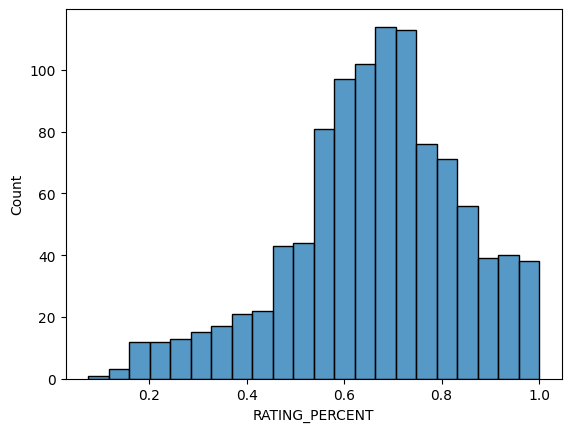

In [26]:
sns.histplot(film_ratings_df['RATING_PERCENT'])

C:\Users\tomdevine\AppData\Local\Temp\ipykernel_34068\3568918750.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(film_ratings_df['RATING_SCALED'])


<Axes: xlabel='RATING_SCALED', ylabel='Density'>

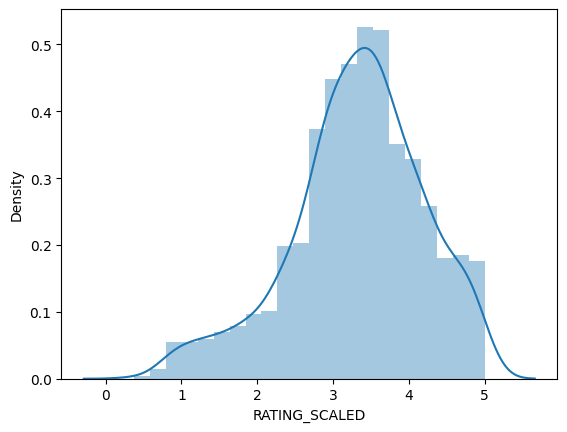

In [27]:
sns.distplot(film_ratings_df['RATING_SCALED'])

In [28]:
def barplot_mean(df, group_col, mean_col, minimum_grouping_count=None):
    df[group_col] = df[group_col].astype(str)
    tmp = df.groupby(group_col).agg({mean_col:['mean', 'count']}).reset_index()
    tmp = tmp[tmp[group_col] != '']
    tmp.columns = ['_'.join(col) if col[0] != group_col else col[0] for col in tmp.columns]
    if minimum_grouping_count is not None:
        tmp = tmp[tmp[mean_col+'_count']>=minimum_grouping_count]
    tmp = tmp.sort_values(mean_col+'_mean', ascending=False)
    tmp[mean_col+'_count'] = tmp[mean_col+'_count'].astype('float64')
    tmp_plot = sns.barplot(data=tmp, y=group_col, x=mean_col+'_mean', hue=mean_col+'_count', dodge=False, palette='Blues')
    plt.title('mean ' + mean_col + ' grouped by ' + group_col)
    return plt.show()

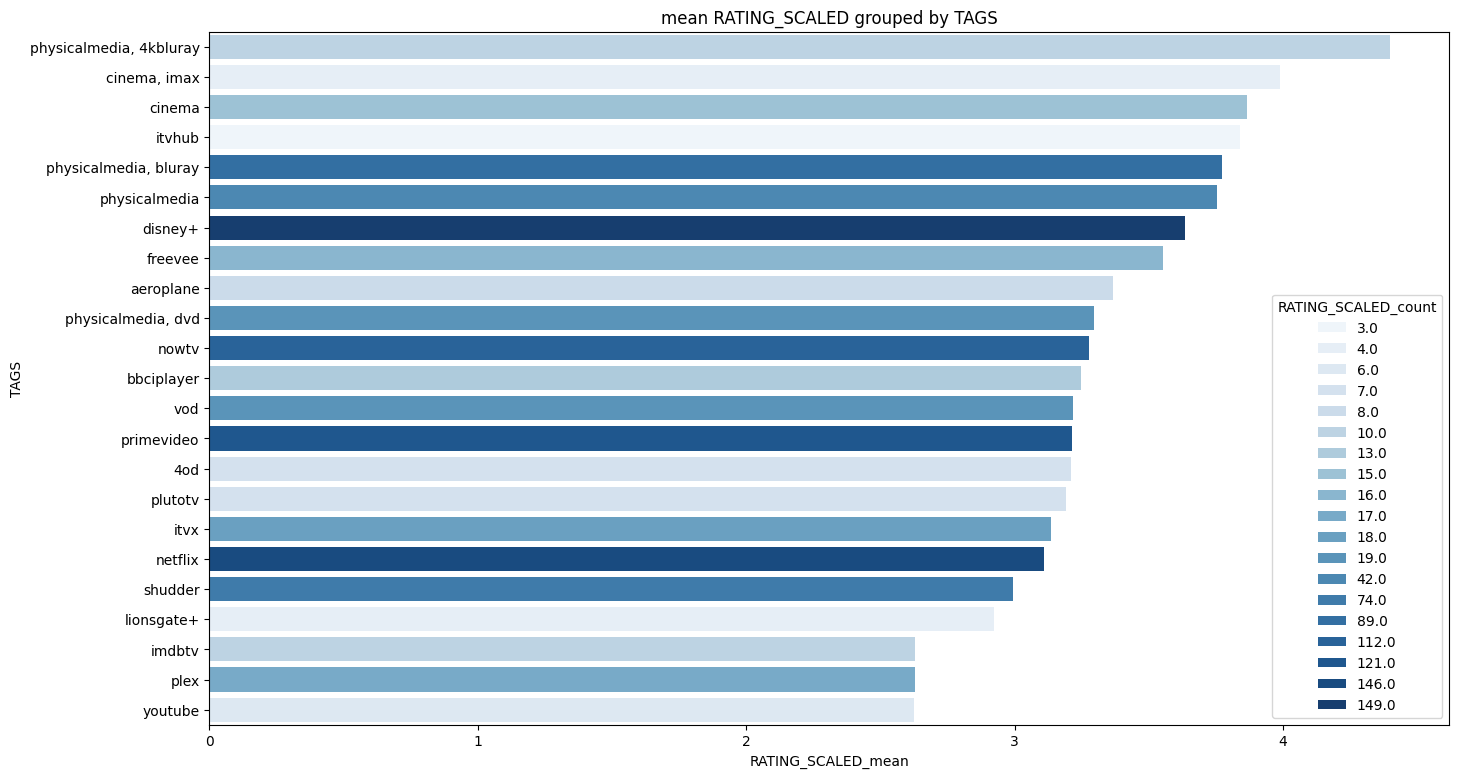

In [29]:
fig = plt.figure(figsize=(16,9))
barplot_mean(feature_diary_df, 'TAGS', 'RATING_SCALED', 2)

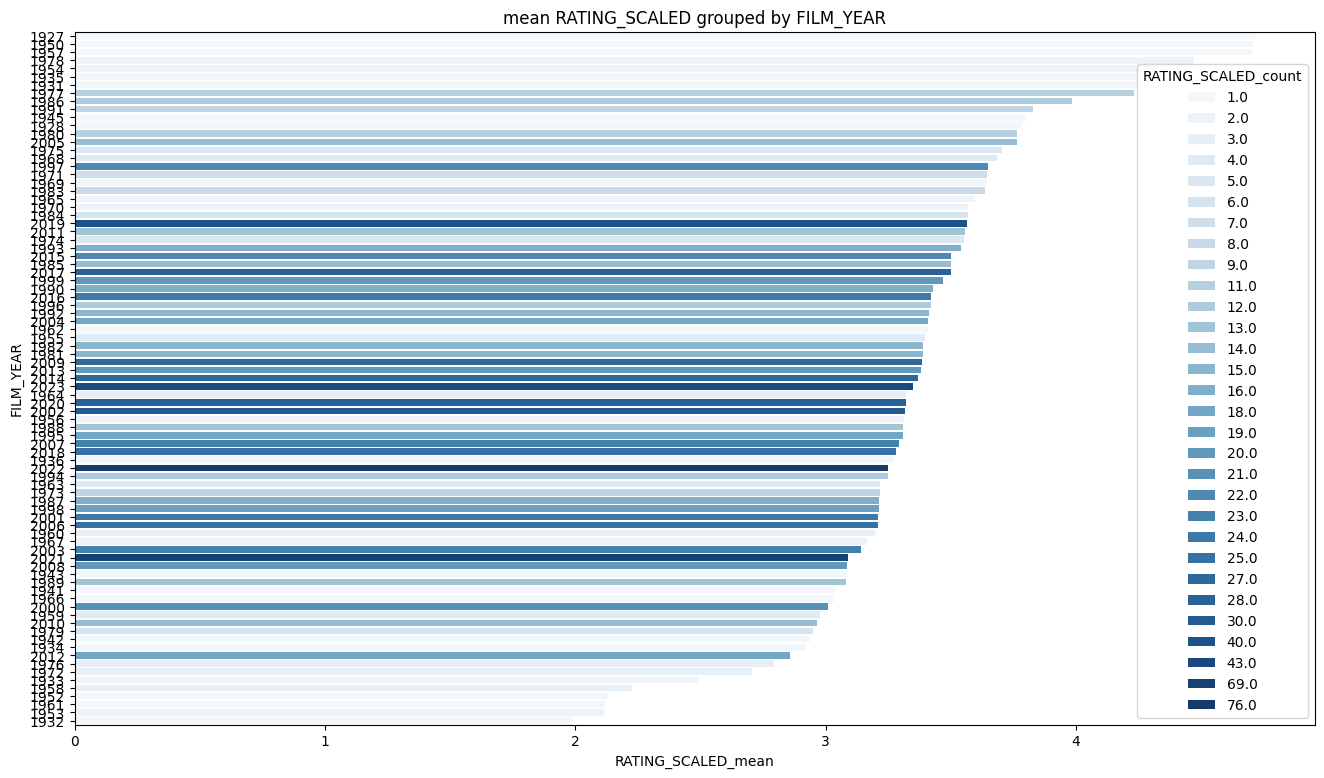

In [30]:
fig = plt.figure(figsize=(16,9))
barplot_mean(feature_diary_df, 'FILM_YEAR', 'RATING_SCALED', 0)

,rating,film_count,rating_str
0,5.0,45.0,5.0 stars
1,4.5,94.0,4.5 stars
2,4.0,171.0,4.0 stars
3,3.5,270.0,3.5 stars
4,3.0,231.0,3.0 stars
5,2.5,103.0,2.5 stars
6,2.0,49.0,2.0 stars
7,1.5,34.0,1.5 stars
8,1.0,28.0,1.0 stars
9,0.5,2.0,0.5 stars


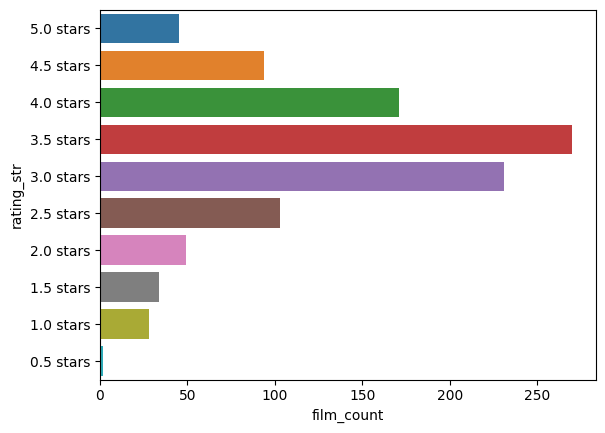

In [33]:
ratings_df = pd.DataFrame(ratings_dict).T.reset_index()[['index', 'RATING_COUNT']]
ratings_df.columns = ['rating', 'film_count']
ratings_df['rating_str'] = ratings_df['rating'].astype(str) + ' stars'
sns.barplot(data=ratings_df, y='rating_str', x='film_count', orient='h')
ratings_df

In [34]:
ordered__film_list = feature_diary_df[['FILM_NAME', 'FILM_POSITION', 'FILM_RATING', 'RATING_SCALED']].groupby(['FILM_NAME', 'FILM_POSITION', 'FILM_RATING']).mean().sort_values('RATING_SCALED', ascending=False).reset_index()
ordered__film_list.iloc[200:220, :]

,FILM_NAME,FILM_POSITION,FILM_RATING,RATING_SCALED
200,Friday the 13th Part 2,201,4.0,4.077485
201,Romeo + Juliet,202,4.0,4.074561
202,The Power of the Dog,203,4.0,4.071637
203,Wind River,204,4.0,4.068713
204,"Synecdoche, New York",205,4.0,4.065789
205,Cronos,206,4.0,4.062865
206,Jaws,207,4.0,4.059942
207,Annabelle Comes Home,208,4.0,4.057018
208,GoodFellas,209,4.0,4.054094
209,The Mummy,210,4.0,4.051170


In [35]:
watched_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watched.csv'))
watched_df.columns = ['WATCH_DATE', 'FILM_NAME', 'FILM_YEAR', 'URI']
watched_df['FILM_ID'] = watched_df['URI'].apply(convert_uri_to_id)
watched_df['WATCHED'] = 1
watched_df

,WATCH_DATE,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
0,2021-01-02,Jumanji,1995,https://boxd.it/1ZLI,f_01ZLI,1
1,2021-01-02,Fatal Attraction,1987,https://boxd.it/1UTC,f_01UTC,1
2,2021-01-03,Punch-Drunk Love,2002,https://boxd.it/20E4,f_020E4,1
3,2021-01-03,Altered States,1980,https://boxd.it/1TBi,f_01TBi,1
4,2021-01-03,The Fear of God: 25 Years of The Exorcist,1998,https://boxd.it/3z48,f_03z48,1
...,...,...,...,...,...,...
2553,2024-01-23,Apocalypto,2006,https://boxd.it/28yy,f_028yy,1
2554,2024-01-24,Now You See Me,2013,https://boxd.it/2Bsu,f_02Bsu,1
2555,2024-01-24,Martin,1977,https://boxd.it/1tJ6,f_01tJ6,1
2556,2024-01-25,The Others,2001,https://boxd.it/27Po,f_027Po,1


In [36]:
watchlist_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watchlist.csv'))
watchlist_df.columns = ['DATE_ADDED', 'FILM_NAME', 'FILM_YEAR', 'URI']
watchlist_df['FILM_ID'] = watchlist_df['URI'].apply(convert_uri_to_id)
watchlist_df['WATCHED'] = 0
watchlist_df

,DATE_ADDED,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
0,2021-01-13,Strange Days,1995.0,https://boxd.it/2aGO,f_02aGO,0
1,2021-01-13,The Lawnmower Man,1992.0,https://boxd.it/1WVK,f_01WVK,0
2,2021-01-13,Judge Dredd,1995.0,https://boxd.it/1Yzm,f_01Yzm,0
3,2021-01-13,Repo Men,2010.0,https://boxd.it/1icK,f_01icK,0
4,2021-01-13,Brainstorm,1983.0,https://boxd.it/1MUW,f_01MUW,0
...,...,...,...,...,...,...
14680,2024-01-26,Night of the Eagles,1989.0,https://boxd.it/1n0E,f_01n0E,0
14681,2024-01-26,Marquis de Sade: Justine,1969.0,https://boxd.it/2oJC,f_02oJC,0
14682,2024-01-26,Eugenie de Sade,1973.0,https://boxd.it/2lgW,f_02lgW,0
14683,2024-01-26,The Adventures of Greyfriars Bobby,2005.0,https://boxd.it/2wcQ,f_02wcQ,0


In [37]:
all_films_df = pd.concat([watched_df.drop(['WATCH_DATE'], axis=1), watchlist_df.drop(['DATE_ADDED'], axis=1)])
all_films_df.head()

,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
0,Jumanji,1995.0,https://boxd.it/1ZLI,f_01ZLI,1
1,Fatal Attraction,1987.0,https://boxd.it/1UTC,f_01UTC,1
2,Punch-Drunk Love,2002.0,https://boxd.it/20E4,f_020E4,1
3,Altered States,1980.0,https://boxd.it/1TBi,f_01TBi,1
4,The Fear of God: 25 Years of The Exorcist,1998.0,https://boxd.it/3z48,f_03z48,1


In [38]:
pd.options.display.max_rows = 9999

In [39]:
all_films_df[all_films_df['FILM_YEAR']==1991]

,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
32,Drop Dead Fred,1991.0,https://boxd.it/1Wpu,f_01Wpu,1
71,The Silence of the Lambs,1991.0,https://boxd.it/2aHW,f_02aHW,1
95,Terminator 2: Judgment Day,1991.0,https://boxd.it/2aGY,f_02aGY,1
298,Cape Fear,1991.0,https://boxd.it/28vu,f_028vu,1
1191,Beauty and the Beast,1991.0,https://boxd.it/1XhG,f_01XhG,1
1192,The Addams Family,1991.0,https://boxd.it/267g,f_0267g,1
1193,Hook,1991.0,https://boxd.it/29nQ,f_029nQ,1
1194,Boyz n the Hood,1991.0,https://boxd.it/29Ug,f_029Ug,1
1195,The Rocketeer,1991.0,https://boxd.it/1WIG,f_01WIG,1
1196,The Fisher King,1991.0,https://boxd.it/2aWM,f_02aWM,1


In [40]:
year_completion_df = all_films_df.groupby('FILM_YEAR').agg({'WATCHED': ['mean', 'count']}).reset_index()
year_completion_df.columns = ['FILM_YEAR', 'COMPLETION_PERCENT', 'TOTAL_FILMS']
year_completion_df2 = year_completion_df[(year_completion_df['FILM_YEAR'] >= 1930) & (year_completion_df['FILM_YEAR'] <= 2022)]
year_completion_df2.sort_values(['COMPLETION_PERCENT', 'FILM_YEAR'], ascending=False)

,FILM_YEAR,COMPLETION_PERCENT,TOTAL_FILMS
122,2019.0,0.241379,580
120,2017.0,0.227599,558
119,2016.0,0.222458,472
116,2013.0,0.202273,440
117,2014.0,0.199195,497
105,2002.0,0.197232,289
107,2004.0,0.192053,302
115,2012.0,0.191919,396
124,2021.0,0.185910,511
118,2015.0,0.185567,485


In [41]:
year_completion_df2

,FILM_YEAR,COMPLETION_PERCENT,TOTAL_FILMS
33,1930.0,0.000000,14
34,1931.0,0.130435,23
35,1932.0,0.068966,29
36,1933.0,0.071429,28
37,1934.0,0.071429,14
38,1935.0,0.055556,18
39,1936.0,0.047619,21
40,1937.0,0.050000,20
41,1938.0,0.000000,21
42,1939.0,0.032258,31


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]),
 [Text(0, 0, '1930.0'),
  Text(1, 0, '1931.0'),
  Text(2, 0, '1932.0'),
  Text(3, 0, '1933.0'),
  Text(4, 0, '1934.0'),
  Text(5, 0, '1935.0'),
  Text(6, 0, '1936.0'),
  Text(7, 0, '1937.0'),
  Text(8, 0, '1938.0'),
  Text(9, 0, '1939.0'),
  Text(10, 0, '1940.0'),
  Text(11, 0, '1941.0'),
  Text(12, 0, '1942.0'),
  Text(13, 0, '1943.0'),
  Text(14, 0, '1944.0'),
  Text(15, 0, '1945.0'),
  Text(16, 0, '1946.0'),
  Text(17, 0, '1947.0'),
  Text(18, 0, '1948.0'),
  Text(19, 0, '1949.0'),
  Text(20, 0, '1950.0'),
  Text(21, 0, '1951.0'),
  Text(22, 0, '1952.0'),
  Text(23, 0,

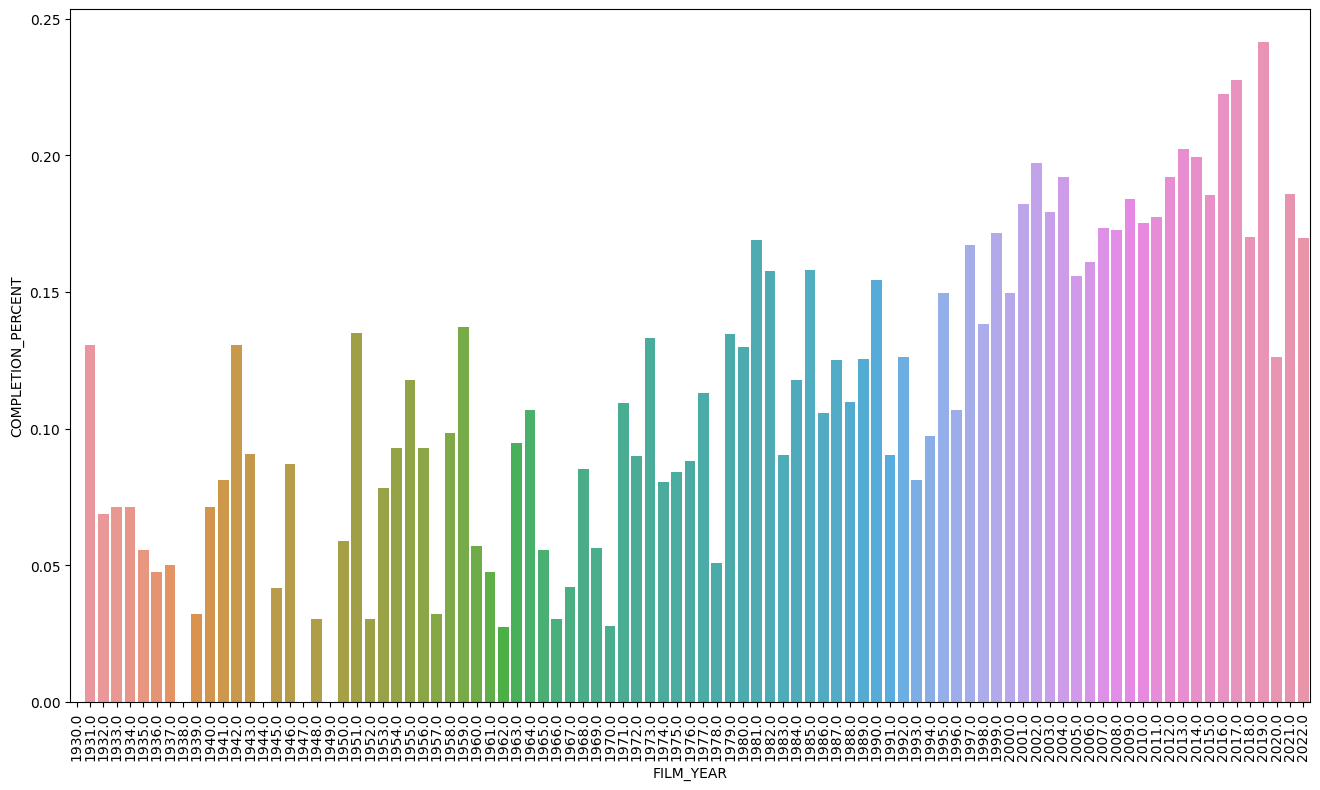

In [42]:
fig = plt.figure(figsize=(16,9))
sns.barplot(data=year_completion_df2, x='FILM_YEAR', y='COMPLETION_PERCENT')
plt.xticks(rotation=90)

In [45]:
cast = movie_dict.get('casts').get('cast')
crew = movie_dict.get('casts').get('crew')
for k in cast[0]:
    print(k, ': ', cast[0][k])

adult :  False
gender :  2
id :  109
known_for_department :  Acting
name :  Elijah Wood
original_name :  Elijah Wood
popularity :  22.601
profile_path :  /7UKRbJBNG7mxBl2QQc5XsAh6F8B.jpg
cast_id :  9
character :  Casey Connor
credit_id :  52fe44e0c3a36847f80af47f
order :  0


In [43]:
diary_df_output['TAGS'].unique()

array(['', 'physicalmedia', 'bbciplayer', 'netflix', 'nowtv', 'disney+',
       'primevideo', 'youtube', 'vod', 'cinema', 'shudder',
       'physicalmedia, bluray', 'physicalmedia, dvd', 'imdbtv',
       'liff, liff2021, cinema', 'physicalmedia, 4kbluray', 'plex',
       'plutotv', '5od', 'cinema, imax', 'freevee', '4od',
       'cinema, lunacinema', 'itvhub', 'livetv', 'dailymotion', 'itvx',
       'wedotv', 'cinema, 70mm, cinerama', 'internet', 'aeroplane',
       'netflx', 'lionsgate+'], dtype=object)

In [45]:
diary_df_output[diary_df_output['TAGS']=='internet']

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH
980,f_01Tj4,2023-03-16,3.5,internet,1
